# NSE Examples

Here we show how to find the NSE state of a set of nuclei.

## Creating an `NSENetwork`

In [1]:
import pynucastro as pyna
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

We start by creating a {py:obj}`Library <pynucastro.rates.library.Library>` object that reads all the ReacLib rates and link different nuclei of choice. 

In [2]:
rl = pyna.ReacLibLibrary()

all_nuclei = ["p", "he4",
              "c12", "n13",
              "o16", "f17", 
              "ne20", "na23",
              "mg24", "al27", "si28",
              "p31", "s32", "cl35",
              "ar36", "k39", "ca40",
              "sc43", "ti44", "v47",
              "cr48", "mn51",
              "fe52","co55","ni56"]

lib = rl.linking_nuclei(all_nuclei)

Then initialize an {py:obj}`NSENetwork <pynucastro.networks.nse_network.NSENetwork>` by using the the rates created by the `Library` object.

In [3]:
nse = pyna.NSENetwork(libraries=lib, use_unreliable_spins=False)

We seek the NSE composition at a specified thermodynamic state, the `NSENetwork` uses `scipy.optimize.fsolve()` to solve the constraint equations for the proton and neutron chemical potentials. Then using this solution, it can compute the mass fractions. The main interface for this is {py:meth}`get_comp_nse(rho, T, ye) <pynucastro.networks.nse_network.NSENetwork.get_comp_nse>` which returns the composition at NSE as a {py:obj}`Composition <pynucastro.networks.rate_collection.Composition>` object.

```{note}
`get_comp_nse()` has options of incorporating Coulomb correction terms by setting `use_coulomb_corr=True`, and to return the proton and neutron chemical potentials by `return_sol=True`.`NSENetwork` also has an option of choosing to be more strict about the confidence of spin data with `use_unreliable_spins=True`.
```

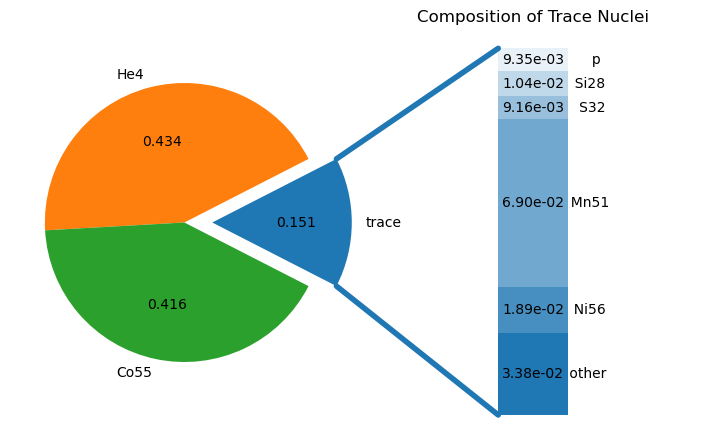

In [4]:
comp, sol = nse.get_comp_nse(1e7, 6e9, 0.50, use_coulomb_corr=True, return_sol=True)
fig = comp.plot()

```{tip}
There is pre-set initial guess for the proton and neutron chemical potentials, however one should adjust the initial guess, accordingly if no solutions are found or if the method is taking a long time to converge.
To pass in the initial guess, set `initial_guess=guess`, where `guess` is a user-supplied list of the form `[mu_p, mu_n]`, where `mu_p` and `mu_n` are the chemical potential for proton and neutron, respectively.
```

We can also explicitly print the composition

In [5]:
for c, v in comp.X.items():
    print(f"{str(c):6} : {v:15.8g}")

p      :    0.0093498981
He4    :      0.43364062
C12    :   7.7285996e-06
N13    :   2.5919027e-10
O16    :   1.5697524e-05
F17    :   1.2715377e-10
Ne20   :   3.0187405e-07
Na23   :   7.2969522e-08
Mg24   :   3.4701942e-05
Al27   :   3.3525822e-05
Si28   :     0.010439163
P31    :    0.0021350073
S32    :    0.0091606019
Cl35   :    0.0040009498
Ar36   :    0.0048794488
K39    :    0.0055527548
Ca40   :    0.0047700285
Sc43   :   0.00037267165
Ti44   :   0.00022927113
V47    :    0.0049046608
Cr48   :    0.0011465823
Mn51   :     0.068958575
Fe52   :    0.0057658969
Co55   :      0.41568674
Ni56   :     0.018915105


In [6]:
print(f"The chemical potential for proton and neutron are {sol[0]:10.7f} and {sol[1]:10.7f}")

The chemical potential for proton and neutron are -7.7387843 and -9.9990481


## NSE variation with temperature

For $\rho = 10^7~\mathrm{g~cm^{-3}}$ and electron fraction, $Y_e = 0.5$, we can explore how the NSE state changes with temperature.

Here we used a guess for chemical potential of proton and neutron of -6.0 and -11.5, respectively.

In [7]:
rho = 1e7
ye = 0.5
temps = np.linspace(2.5, 12.0, 100)
X_s = []

guess = [-6.0, -11.5]
for i, temp in enumerate(temps):
    nse_comp, sol = nse.get_comp_nse(rho, temp*1.0e9, ye, init_guess=guess, 
                                     use_coulomb_corr=True, return_sol=True)
    guess = sol
    nse_X_s = [nse_comp.X[nuc] for nuc in nse_comp.X]
    X_s.append(nse_X_s)

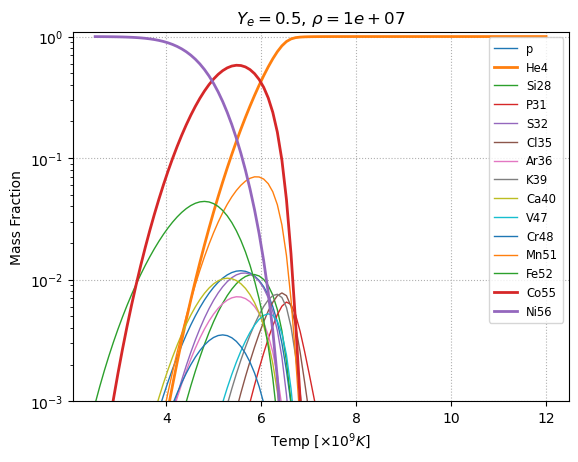

In [8]:
X_s = np.array(X_s)
nuc_names = nse.get_nuclei()

low_limit = 1e-3
fig, ax = plt.subplots()

for k in range(len(nuc_names)):
    if np.max(X_s[:, k]) <= low_limit:
        continue
    lw = 2 if np.max(X_s[:, k]) > 0.1 else 1
    ax.plot(temps, X_s[:, k], linewidth=lw, label=str(nuc_names[k]))

ax.legend(loc="best", fontsize="small", ncol=1)
ax.set_xlabel(r'Temp $[\times 10^9 K]$')
ax.set_ylabel('Mass Fraction')
ax.set_yscale('log')
ax.set_ylim([low_limit, 1.1])
ax.set_title(rf"$Y_e = {ye}$, $\rho = {rho:6.3g}$")
ax.grid(ls=":")

## NSE variation with $Y_e$

For $\rho = 10^7~\mathrm{g~cm^{-3}}$ and a relatively high temperature of $T = 6 \times 10^9~\mathrm{K}$, we can look at how the NSE state changes with varying $Y_e$.

Note: there will be a lowest $Y_e$ that is attainable by the network, depending on what species are represented. The NSE configuration with the lowest $Y_e$ is usually difficult to find and unlikely to happen in reality. For our current example network, achieving the lowest $Y_e$ means that mass fraction for N13 = 1. As long as protons are in the network, we can reach a $Y_e$ of $1$.

In [9]:
ye_low = min(nuc.Z/nuc.A for nuc in nse.unique_nuclei)

In [10]:
rho = 1e7
ye_s = np.linspace(ye_low, 0.65, 100)[1:]
temp = 6.0e9
X_s_1 = []

guess = [-6.0, -11.5]
for i, ye in enumerate(ye_s):
    nse_comp_1, sol = nse.get_comp_nse(rho, temp, ye, init_guess=guess, 
                                       use_coulomb_corr=True, return_sol=True)
    guess = sol
    nse_X_s_1 = [nse_comp_1.X[nuc] for nuc in nse_comp_1.X]
    X_s_1.append(nse_X_s_1)

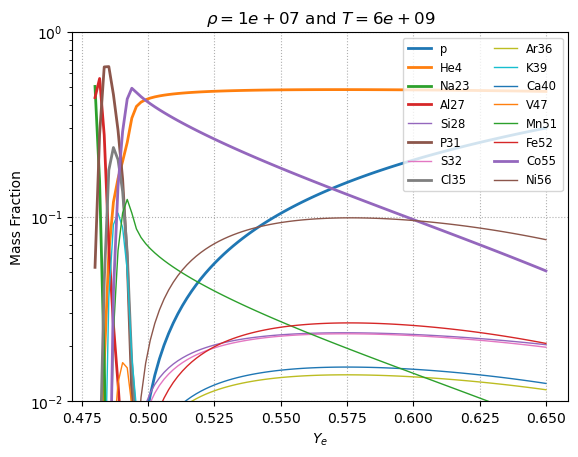

In [11]:
X_s_1 = np.array(X_s_1)
nuc_names = nse.get_nuclei()

fig, ax = plt.subplots()

for k in range(len(nuc_names)):
    if np.max(X_s_1[:, k]) <= 1e-2:
        continue
    lw = 2 if np.max(X_s_1[:, k]) > 0.2 else 1
    ax.plot(ye_s, X_s_1[:, k], linewidth=lw, label=str(nuc_names[k]))

ax.legend(loc="best", fontsize="small", ncol=2)
ax.set_xlabel(r'$Y_e$')
ax.set_ylabel('Mass Fraction')
ax.set_yscale('log')
ax.set_ylim([1e-2, 1])
ax.set_title(rf"$\rho = {rho:6.3g}$ and $T={temp:6.3g}$")
ax.grid(ls=":")